In [2]:
import struct
import numpy as np
import matplotlib.pyplot as plt
# from pynq import Overlay
# from pynq import MMIO

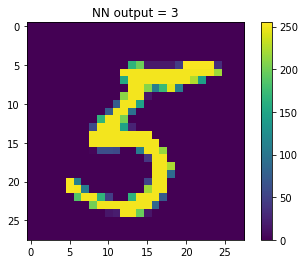

3


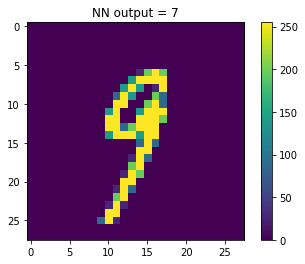

7


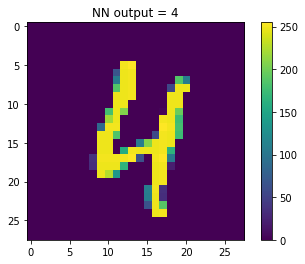

4


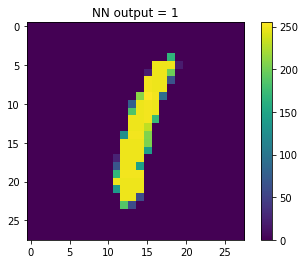

1


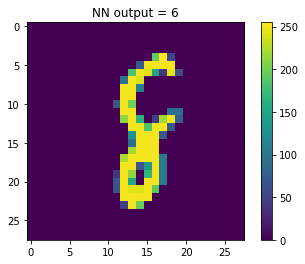

6


In [13]:
from pynq import Overlay 
from PIL import Image 
from time import sleep
import matplotlib.pyplot as plt

# connect network
platform = Overlay("design_1.bit")
# neural_net = platform.m_neural_network14_1_0
neural_net = platform.m_nn_0

# Address for in and out ports
NEURAL_NET_IN_ADDR = 3 * 4
NEURAL_NET_IN_COUNT = 4 * 4
NEURAL_NET_OUT_ADDR = 5 * 4
NEURAL_NET_IN_ADDR_RESET = 6 * 4

image_list = ["pic5.png", "pic9.png", "pic4.png", "pic1.png", "pic8.png"]
for file_name in image_list:
    neural_net.write(NEURAL_NET_IN_ADDR_RESET, int(0))
    # Prepear image
    image = Image.open(file_name)
    pixel_values = list (image.getdata())
    width, height = image.size
    pixel_val = [(pixel - 127.5) / 127.5 for pixel in pixel_values] 
    pixel_values = [pixel_val[i * width: (i + 1) * width] 
                    for i in range(height)]
    
    # pixel counter for correct transfer of each pixels
    pixel_count = 1
    output = neural_net.read(NEURAL_NET_OUT_ADDR) # read answer
    neural_net.write(NEURAL_NET_IN_ADDR_RESET, 1)
    output = neural_net.read(NEURAL_NET_OUT_ADDR) # read answer
    for i in range (height):
        for j in range(width):
            neural_net.write(NEURAL_NET_IN_COUNT, pixel_count) # send counter 
             # send pixel in Q12.12
            neural_net.write(NEURAL_NET_IN_ADDR, int(pixel_values[i][j] * 2**12))
            pixel_count = pixel_count + 1


    output = neural_net.read(NEURAL_NET_OUT_ADDR) # read answer
    plt.imshow(image)
    plt.title(f'NN output = {output}')
    plt.colorbar()
    plt.show()
    print (output)
    neural_net.write(NEURAL_NET_IN_ADDR_RESET, int(0))
#     sleep(2)

In [16]:
IP_CORE_VERSION_ADDR = 0x00
core_magic_offset = 0x08

IP_BASE_ADDR= 0x43c00000
ADDR_RANDE = 0xFF    
mmio = MMIO(IP_BASE_ADDR, ADDR_RANDE)

res = mmio.read(offset=IP_CORE_VERSION_ADDR)
print('IP core version = ', hex(res))

res = mmio.read(offset=core_magic_offset)
print('IP core magic = ', hex(res))


IP core version =  0x1
IP core magic =  0x47465550


In [14]:
import struct
import numpy as np
from pynq import Overlay
from PIL import Image
from time import sleep
import matplotlib.pyplot as plt

# connect network
platform = Overlay("design_1.bit")
neural_net = platform.m_nn_0

# Address for in and out ports
NEURAL_NET_IN_ADDR = 3 * 4
NEURAL_NET_IN_COUNT = 4 * 4
NEURAL_NET_OUT_ADDR = 5 * 4
NEURAL_NET_IN_ADDR_RESET = 6 * 4

# load image from MNIST 
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        # Чтение заголовка
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

# Load labels from MNIST
def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        # Чтение заголовка
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Proceccing image
def predict(image):
    neural_net.write(NEURAL_NET_IN_ADDR_RESET, int(0))
    pixel_values = list(image.getdata())
    width, height = image.size
    pixel_val = [(pixel - 127.5) / 127.5 for pixel in pixel_values] 
    pixel_values = [pixel_val[i * width: (i + 1) * width] 
                    for i in range(height)]
    
    pixel_count = 1
    output = neural_net.read(NEURAL_NET_OUT_ADDR) # read answer
    neural_net.write(NEURAL_NET_IN_ADDR_RESET, 1)
    output = neural_net.read(NEURAL_NET_OUT_ADDR) # read answer
    # pixel counter for correct transfer of each pixels
    for i in range(height):
        for j in range(width):
            neural_net.write(NEURAL_NET_IN_COUNT, pixel_count) 
            neural_net.write(NEURAL_NET_IN_ADDR, int(pixel_values[i][j] * 2**12))
            pixel_count += 1
    
    output = neural_net.read(NEURAL_NET_OUT_ADDR)
#     print(output)
    neural_net.write(NEURAL_NET_IN_ADDR_RESET, int(0))
    return output

# Empty confusion matrix
def create_confusion_matrix(num_classes):
    return np.zeros((num_classes, num_classes), dtype=int)

# Update confusion matrix
def update_confusion_matrix(conf_matrix, true_label, predicted_label):
    conf_matrix[true_label][predicted_label] += 1

num_classes = 10
conf_matrix = create_confusion_matrix(num_classes)

# path to MNIST
mnist_images_file = 't10k-images-idx3-ubyte'  
mnist_labels_file = 't10k-labels-idx1-ubyte' 

images = load_mnist_images(mnist_images_file)
true_labels = load_mnist_labels(mnist_labels_file)
count = 0
count_15 = 0;
# Test on FPGA and create a confusion matrix
for img_array, true_label in zip(images, true_labels):
#     if (count < 1000):
    neural_net.write(NEURAL_NET_IN_ADDR_RESET, 0)
#         sleep(2)
    img = Image.fromarray(img_array) 
#     sleep(0.05)
    prediction = predict(img)
    print(prediction)
    print(count)
#     if (prediction != 15):
    update_confusion_matrix(conf_matrix, true_label, prediction)
#     else:
#         count_15 += 1  
    count += 1


print("Confusion matrix:")
print(conf_matrix)

7
0
6
1
1
2
0
3
4
4
1
5
4
6
7
7
6
8
4
9
0
10
6
11
4
12
0
13
1
14
5
15
7
16
7
17
6
18
4
19
7
20
6
21
7
22
5
23
7
24
0
25
7
26
4
27
0
28
1
29
3
30
1
31
3
32
6
33
7
34
2
35
7
36
1
37
3
38
1
39
1
40
7
41
4
42
1
43
3
44
5
45
1
46
2
47
4
48
4
49
6
50
3
51
4
52
3
53
6
54
0
55
4
56
1
57
7
58
7
59
7
60
6
61
6
62
3
63
7
64
4
65
7
66
4
67
3
68
0
69
7
70
0
71
2
72
7
73
1
74
7
75
3
76
7
77
1
78
7
79
7
80
6
81
2
82
7
83
4
84
4
85
7
86
3
87
6
88
1
89
3
90
6
91
1
92
3
93
1
94
4
95
1
96
7
97
6
98
7
99
6
100
0
101
5
102
4
103
7
104
4
105
2
106
1
107
9
108
4
109
1
110
7
111
3
112
7
113
7
114
6
115
4
116
4
117
4
118
7
119
4
120
6
121
7
122
6
123
4
124
7
125
0
126
5
127
8
128
5
129
6
130
6
131
5
132
7
133
1
134
1
135
0
136
1
137
6
138
4
139
6
140
7
141
7
142
1
143
7
144
1
145
1
146
2
147
0
148
1
149
9
150
7
151
5
152
5
153
1
154
4
155
6
156
0
157
3
158
7
159
4
160
6
161
5
162
4
163
6
164
5
165
4
166
5
167
1
168
4
169
4
170
7
171
2
172
3
173
2
174
7
175
1
176
6
177
1
178
1
179
1
180
6
181
5
182
0
183
6
184


1
1329
4
1330
5
1331
6
1332
0
1333
5
1334
2
1335
1
1336
6
1337
1
1338
3
1339
5
1340
2
1341
4
1342
7
1343
6
1344
6
1345
7
1346
7
1347
2
1348
2
1349
1
1350
1
1351
2
1352
1
1353
3
1354
7
1355
7
1356
7
1357
1
1358
7
1359
1
1360
7
1361
6
1362
7
1363
6
1364
2
1365
7
1366
3
1367
1
1368
7
1369
5
1370
8
1371
7
1372
6
1373
3
1374
1
1375
5
1376
6
1377
6
1378
0
1379
7
1380
2
1381
4
1382
3
1383
3
1384
7
1385
7
1386
6
1387
6
1388
8
1389
0
1390
4
1391
1
1392
7
1393
7
1394
2
1395
7
1396
1
1397
8
1398
0
1399
6
1400
7
1401
7
1402
1
1403
0
1404
5
1405
5
1406
2
1407
0
1408
7
1409
3
1410
0
1411
1
1412
4
1413
7
1414
6
1415
0
1416
9
1417
7
1418
4
1419
6
1420
4
1421
4
1422
7
1423
1
1424
4
1425
3
1426
4
1427
9
1428
4
1429
1
1430
7
1431
2
1432
1
1433
1
1434
7
1435
6
1436
4
1437
0
1438
7
1439
6
1440
7
1441
3
1442
3
1443
7
1444
0
1445
1
1446
6
1447
1
1448
7
1449
6
1450
2
1451
9
1452
4
1453
0
1454
7
1455
6
1456
0
1457
6
1458
2
1459
3
1460
4
1461
3
1462
7
1463
7
1464
1
1465
7
1466
4
1467
0
1468
6
1469
5
1470
5
1471

3
2502
2
2503
1
2504
7
2505
0
2506
7
2507
6
2508
4
2509
7
2510
3
2511
8
2512
7
2513
4
2514
6
2515
7
2516
2
2517
5
2518
1
2519
1
2520
7
2521
3
2522
7
2523
1
2524
3
2525
5
2526
0
2527
4
2528
1
2529
4
2530
0
2531
6
2532
3
2533
3
2534
1
2535
0
2536
4
2537
7
2538
7
2539
5
2540
1
2541
6
2542
1
2543
7
2544
3
2545
5
2546
7
2547
4
2548
3
2549
0
2550
3
2551
7
2552
1
2553
5
2554
3
2555
6
2556
7
2557
5
2558
5
2559
6
2560
1
2561
6
2562
7
2563
7
2564
7
2565
3
2566
7
2567
0
2568
3
2569
6
2570
0
2571
2
2572
1
2573
7
2574
3
2575
1
2576
7
2577
7
2578
8
2579
6
2580
5
2581
7
2582
3
2583
6
2584
7
2585
3
2586
3
2587
7
2588
1
2589
1
2590
7
2591
0
2592
0
2593
3
2594
7
2595
2
2596
3
2597
1
2598
1
2599
8
2600
6
2601
2
2602
9
2603
5
2604
7
2605
5
2606
1
2607
1
2608
4
2609
1
2610
5
2611
1
2612
4
2613
8
2614
4
2615
3
2616
7
2617
3
2618
0
2619
6
2620
2
2621
7
2622
3
2623
3
2624
1
2625
1
2626
0
2627
7
2628
3
2629
4
2630
6
2631
3
2632
4
2633
3
2634
7
2635
8
2636
7
2637
0
2638
3
2639
7
2640
0
2641
7
2642
6
2643
5
2644

2
3675
4
3676
0
3677
4
3678
1
3679
0
3680
3
3681
6
3682
6
3683
4
3684
4
3685
3
3686
4
3687
6
3688
1
3689
6
3690
5
3691
7
3692
7
3693
1
3694
7
3695
2
3696
6
3697
0
3698
1
3699
4
3700
3
3701
7
3702
1
3703
1
3704
6
3705
0
3706
7
3707
6
3708
7
3709
0
3710
9
3711
6
3712
7
3713
6
3714
3
3715
7
3716
3
3717
9
3718
7
3719
7
3720
7
3721
4
3722
7
3723
0
3724
6
3725
7
3726
4
3727
4
3728
2
3729
7
3730
2
3731
1
3732
7
3733
0
3734
0
3735
7
3736
5
3737
3
3738
3
3739
3
3740
1
3741
3
3742
7
3743
6
3744
1
3745
3
3746
1
3747
6
3748
7
3749
5
3750
6
3751
7
3752
7
3753
5
3754
4
3755
3
3756
1
3757
4
3758
7
3759
7
3760
1
3761
6
3762
4
3763
0
3764
1
3765
3
3766
1
3767
0
3768
7
3769
4
3770
6
3771
2
3772
3
3773
0
3774
2
3775
1
3776
1
3777
0
3778
1
3779
6
3780
1
3781
7
3782
7
3783
1
3784
7
3785
1
3786
7
3787
5
3788
1
3789
0
3790
7
3791
4
3792
4
3793
1
3794
3
3795
1
3796
5
3797
4
3798
7
3799
6
3800
6
3801
2
3802
0
3803
7
3804
0
3805
7
3806
1
3807
1
3808
1
3809
4
3810
4
3811
3
3812
8
3813
5
3814
1
3815
5
3816
4
3817

IndexError: index 15 is out of bounds for axis 0 with size 10

In [13]:
print(count_15)

27


In [ ]:
import struct
import numpy as np
from pynq import Overlay
from PIL import Image
from time import sleep
import matplotlib.pyplot as plt

# connect network
platform = Overlay("design_1.bit")
neural_net = platform.m_nn_0

# Address for in and out ports
NEURAL_NET_IN_ADDR = 3 * 4
NEURAL_NET_IN_COUNT = 4 * 4
NEURAL_NET_OUT_ADDR = 5 * 4
NEURAL_NET_IN_ADDR_RESET = 6 * 4

# load image from MNIST 
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        # Чтение заголовка
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

# Load labels from MNIST
def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        # Чтение заголовка
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Proceccing image
def predict(image):
    neural_net.write(NEURAL_NET_IN_ADDR_RESET, int(0))
#     pixel_values = list(image.getdata())
    pixel_values = image
    
    pixel_count = 1
    output = neural_net.read(NEURAL_NET_OUT_ADDR) # read answer
    neural_net.write(NEURAL_NET_IN_ADDR_RESET, 1)
    output = neural_net.read(NEURAL_NET_OUT_ADDR) # read answer
    # pixel counter for correct transfer of each pixels
    for i in range(784):
#         for j in range(28):
            neural_net.write(NEURAL_NET_IN_COUNT, pixel_count) 
            neural_net.write(NEURAL_NET_IN_ADDR, int(pixel_values[i] * 2**12))
            pixel_count += 1
    
    output = neural_net.read(NEURAL_NET_OUT_ADDR)
#     print(output)
    neural_net.write(NEURAL_NET_IN_ADDR_RESET, int(0))
    return output

# Empty confusion matrix
def create_confusion_matrix(num_classes):
    return np.zeros((num_classes, num_classes), dtype=int)

# Update confusion matrix
def update_confusion_matrix(conf_matrix, true_label, predicted_label):
    conf_matrix[true_label][predicted_label] += 1

num_classes = 10
conf_matrix = create_confusion_matrix(num_classes)

# path to MNIST
mnist_images_file = 't10k-images-idx3-ubyte'  
mnist_labels_file = 't10k-labels-idx1-ubyte' 
normalized_images_file = "normalized_images.npy"  

images = np.load(normalized_images_file)
true_labels = load_mnist_labels(mnist_labels_file)
count = 0
count_15 = 0;

# Test on FPGA and create a confusion matrix
for img_array, true_label in zip(images, true_labels):
#     if (count < 1000):
    neural_net.write(NEURAL_NET_IN_ADDR_RESET, 0)

#     img = Image.fromarray(img_array) 
# #     sleep(0.05)
#     print(img_array)
    prediction = predict(img_array)
    print(f"prediction = {prediction}, true = {true_label}")
    print(count)
    if (prediction != 15):
        update_confusion_matrix(conf_matrix, true_label, prediction)
    else:
        count_15 += 1  
    count += 1


print("Confusion matrix:")
print(conf_matrix)

## Load saved files

In [5]:
normalized_images_file = "normalized_images.npy" 
images = np.load(normalized_images_file)
img_line = images[0,:]
print(img_line)

[-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         